## Alla Chepurova, BS-DS-18-01 

a.chepurova@innopolis.university

In this lab we will learn, how vector representations of different objects can be obtained, and how they can be utilized for recommendations and search.

# 1. [40] If there's no asparagus in Innopolis...

When you find something that you like - whether it is a poem, song, or image, it's often useful to have an option to find similar items, such that you can enjoy songs of the same kind, for example. For this there exist **recommender systems**, and we will build one today. Given a dataset on nutrition of some products, you will be able to search for similar ones, e.g. for replacement in your daily meal: what if you don't have good asparagus in Innopolis?

The recommender system will be based on the vector-space model + dimensionality reduction + cosine similarity measure.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1.1. Reading the dataset

Next block reads the data from a CSV dataset: https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/nutrition.csv

You can also see this data on GitHub as a beatuful table https://github.com/IUCVLab/information-retrieval/blob/main/datasets/nutrition.csv

In [3]:
# you will need internet connection for this block
csv_url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/nutrition.csv"
dataset = pd.read_csv(csv_url)

# there are no (0) saturated fats in vegetables, that's why we replace N/A values with 0
dataset = dataset.fillna(0)

classes_list = dataset["Food Type"][1:].values
names = dataset["Food and Serving"][1:].values
names = [name.split(',')[0] for name in names]

dimensions = dataset.columns[1:]

print("Names:", *names[:5], "...", sep=" | ")
print()
print("Classes:", *set(classes_list), sep=" | ")
print()
print("Dimensions:", *dimensions[:5], "...", sep=" | ")

dataset.head()

Names: | Asparagus | Bell Pepper | Broccoli | Carrot | Cauliflower | ...

Classes: | Fruits Serving Size (gram weight/ounce weight) | Vegetables, Serving Size (gram weight/ ounce weight) | Seafood, Serving Size (84 g/3 oz)

Dimensions: | Calories | Calories from Fat | Total Fat 1 | Total Fat 2 | Sodium 1 | ...


,Food and Serving,Calories,Calories from Fat,Total Fat 1,Total Fat 2,Sodium 1,Sodium 2,Potassium 1,Potassium 2,Total Carbo-hydrate 1,...,Protein,Vitamin A,Vitamin C,Calcium,Iron,Saturated Fat,Saturated Fat 2,Chole-sterol 1,Chole-sterol 2,Food Type
0,0,0.0,0.0,(g),(%DV),(g),(%DV),(g),(%DV),(g),...,(g),(%DV),(%DV),(%DV),(%DV),(%DV),(mg),(%DV),(mg),0
1,"Asparagus, 5 spears (93 g/3.3 oz)",20.0,0.0,0,0,0,0,230,7,4,...,2,10,15,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
2,"Bell Pepper, 1 medium (148 g/5.3 oz)",25.0,0.0,0,0,40,2,220,6,6,...,1,4,190,2,4,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
3,"Broccoli, 1 medium stalk (148 g/5.3 oz)",45.0,0.0,0.5,1,80,3,460,13,8,...,4,6,220,6,6,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."
4,"Carrot, 1 carrot, 7"" long, 1 1/4"" diameter (78...",30.0,0.0,0,0,60,3,250,7,7,...,1,110,10,2,2,0,0,0,0,"Vegetables, Serving Size (gram weight/ ounce w..."


## 1.2. Assigning colors each food item
Building a `color_list` which attributes a color to each item.

In [4]:
classes = list(set(classes_list))
colors = ["red", "green", "blue", "black", "magenta"]
class_colors = {}
for i in range(len(classes)):
    class_colors[classes[i]] = colors[i % len(colors)]
    
print(class_colors)
color_list = [class_colors[a] for a in classes_list]

{'Fruits Serving Size (gram weight/ounce weight)': 'red', 'Vegetables, Serving Size (gram weight/ ounce weight)': 'green', 'Seafood, Serving Size (84 g/3 oz)': 'blue'}


## 1.3. Plotting functions

We will use these functions to visualize data in 2D and 3D.

In [5]:
def show_points_2d(X, Y, xaxis, yaxis):
    global names, classes_list, class_colors
    plt.figure(figsize=(12,8))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    classes = set()
    for x, y, name, label in zip(X, Y, names, classes_list):
        if not label in classes:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label], label=label)
            classes.add(label)
        else:
            plt.plot([x], [y], "o", markersize=20, color=class_colors[label])
        plt.text(x, y, name)
    plt.legend()
    plt.axvline(0)
    plt.axhline(0)
    plt.show()
    
def show_points_3d(X, Y, Z):
    global color_list
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    for x, y, z, color in zip(X, Y, Z, color_list):
        ax.scatter([x], [y], [z], marker='o', color=color)
    plt.show()
    
def show_matrix(A, xaxis, yaxis):
    plt.figure(figsize=(15,10))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.imshow(A)
    plt.show()    

## 1.4. Data Visualization
Matrix `A` will hold numerical data from dataset. It has (61 items)x(22 features) size. In "real" tasks this could be (1B users)x(300 features). In such case each additional feature would cost 8GB of storage. It can be a good idea to cut redundant dimensions.

Raw values, columns are objects (61, 22)


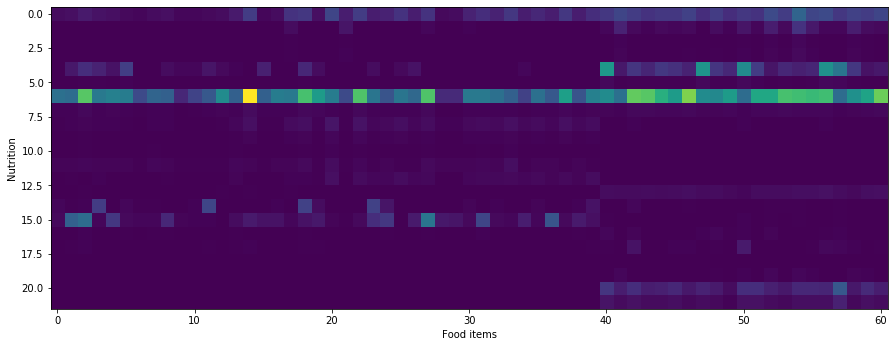

2 random dimensions distribution


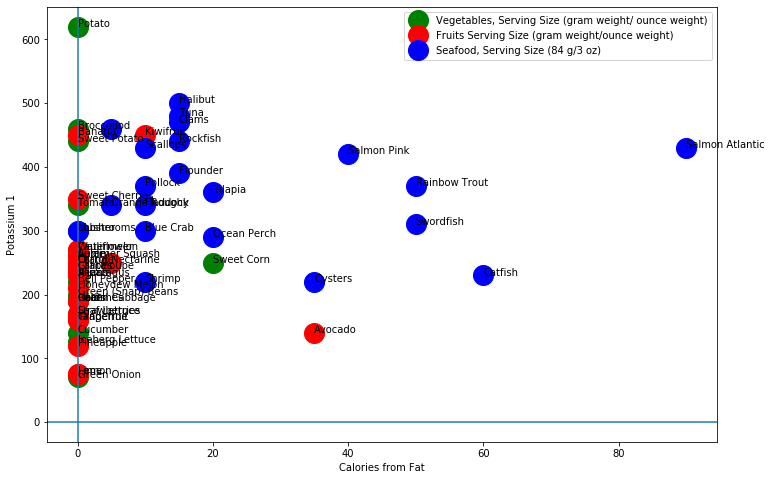

In [6]:
A = np.array(dataset.values[1:,1:-1].astype(float))
print("Raw values, columns are objects", A.shape)
show_matrix(A.T, "Food items", "Nutrition")

print("2 random dimensions distribution")
show_points_2d(A.T[1], A.T[6], dimensions[1], dimensions[6])

## 1.5. [10] Dimensionality reduction with Principal Components Analysis
Principal components are the dimensions, which express **dataset diversity** in the best way: the **variance** is maximized along these dimensions. Thus, we can keep only most valuable ones if we are sure they distiguish our data well. Let's keep 3 principal components. **Fill in the code to apply PCA to our data**.

In [8]:
from sklearn.decomposition import PCA
k = 3
pca = PCA(n_components=k)
#TODO apply PCA to matrix A, and save the results to A_pca
A_pca = pca.fit_transform(A)

In [9]:
assert A_pca.shape == (61, 3)

Check how much variance is explained by the first `k` components. Refer to [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [14]:
# TODO compute the value
explainted_variance_ratio =  np.sum(pca.explained_variance_ratio_)#...

In [15]:
explainted_variance_ratio

0.9091955697253442

In [16]:
assert explainted_variance_ratio > 0.9, "Something went wrong with PCA"

Now, let's **visualize** the data after transformation applied.

2 first dimensions


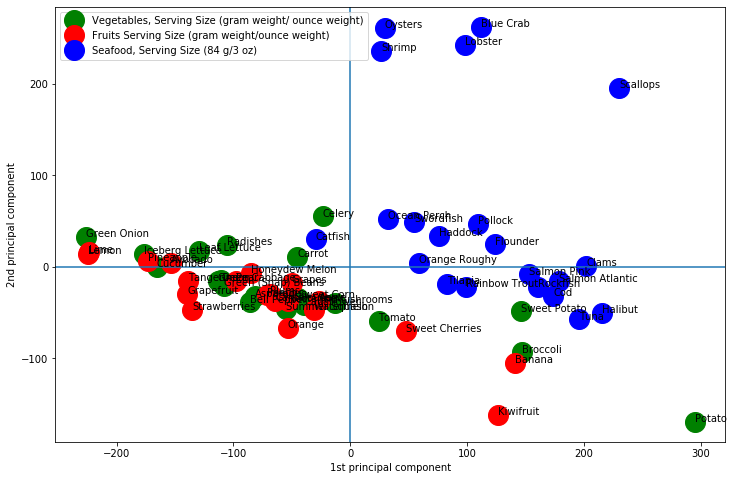

3 first dimensions


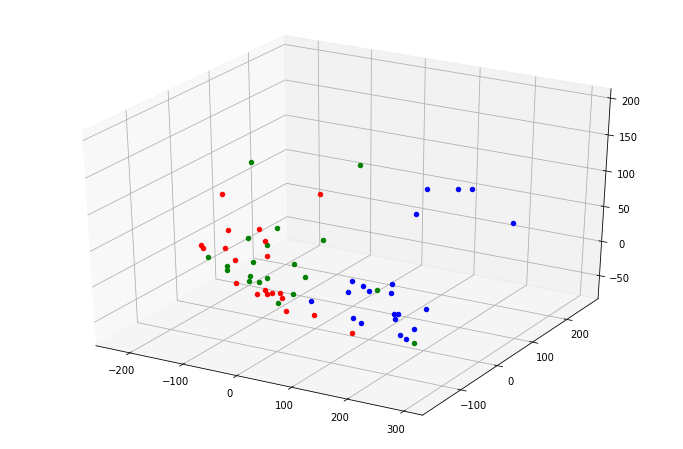

In [19]:
print("2 first dimensions")
show_points_2d(A_pca.T[0], A_pca.T[1], "1st principal component", "2nd principal component")
print("3 first dimensions")
show_points_3d(A_pca.T[0], A_pca.T[1], A_pca.T[2])

## 1.5. [10] Dimensionality reduction with SVD

SVD is not appying centering at the first stage. Instead of variance, it preserves cosine similaity measure, which is more interesting in our case.

In [35]:
from numpy.linalg import svd
k = 3

#TODO apply SVD to matrix A, and save the results to A_svd
U, sigma, V = svd(A)

U_ =  U[:, :k]
S_ =  np.diag(sigma[:k])
V_ =  V[:k, :]

A_svd = U_ @ S_
print(A_svd.shape)

(61, 3)


In [36]:
assert A_svd.shape == (61, 3)

How it looks like?

2 first dimensions


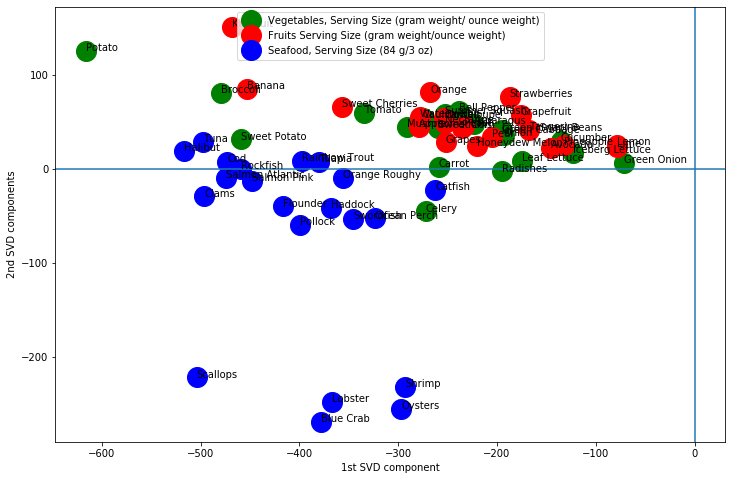

3 first dimensions


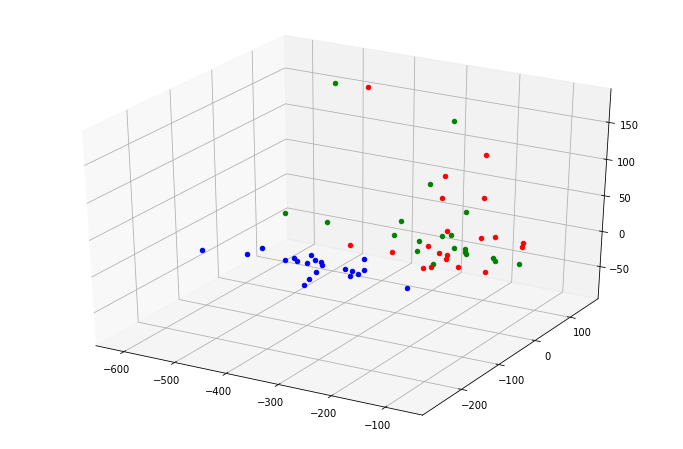

In [37]:
print("2 first dimensions")
show_points_2d(A_svd.T[0], A_svd.T[1], "1st SVD component", "2nd SVD components")
print("3 first dimensions")
show_points_3d(A_svd.T[0], A_svd.T[1], A_svd.T[2])

## 1.6. [10] Norming
It can happen, that some food is more "watered" than the others. See, how different are celery and popatos in terms of calories. Thus, the norm of each item in dataset can be different, and we cannot easily use $L_2$ distance to estimate the difference. But what we can use - [*cosine similarity*](https://en.wikipedia.org/wiki/Cosine_similarity). Cosine similarity shows, how 2 items are "about the same" even if nutrition is of different scale. Look at the formula of cosine similarity: you will find out that if both vectors are **normed**, then $cos(a, b) = a\cdot b$.

**Thus, your task is to norm the dataset vector-wise (row-wise).**

In [145]:
def norm_vectors(A):
    An = A.copy()
    for i in range(len(An)):
        An[i] = An[i] / np.linalg.norm(An[i])
    return An

How it looks now?

2 first dimensions of PCA


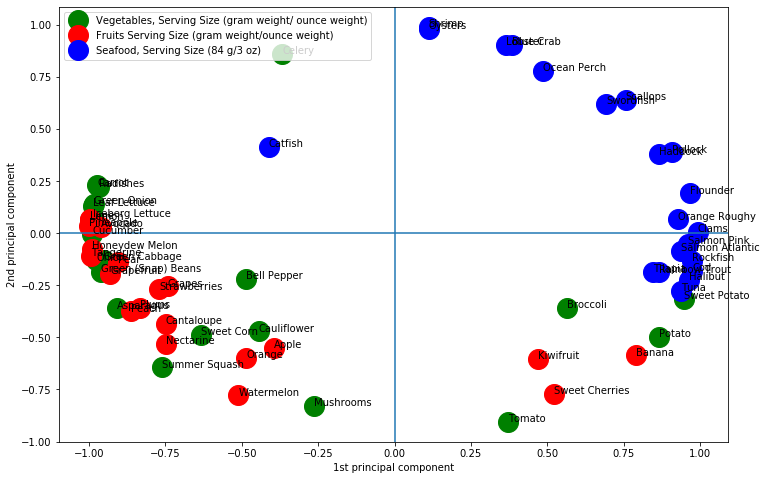

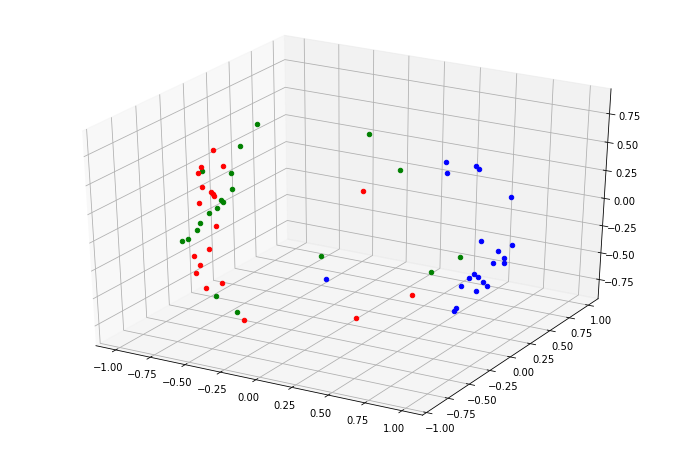

In [146]:
A_pca_norm = norm_vectors(A_pca)

print("2 first dimensions of PCA")
show_points_2d(A_pca_norm.T[0], A_pca_norm.T[1], "1st principal component", "2nd principal component")
show_points_3d(A_pca_norm.T[0], A_pca_norm.T[1], A_pca_norm.T[2])

2 first dimensions of SVD


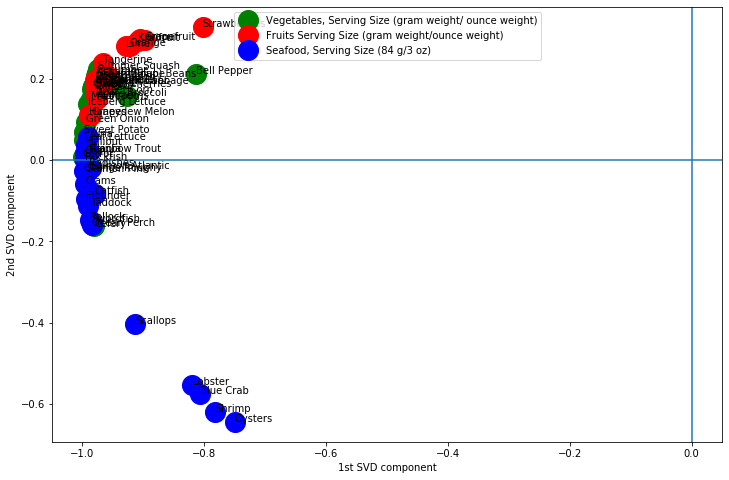

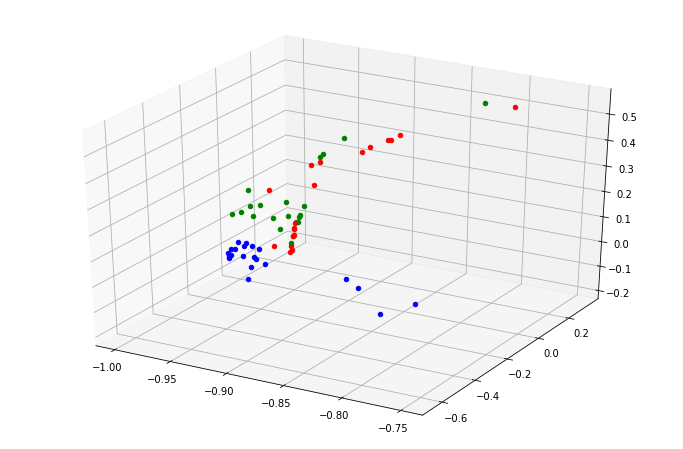

In [147]:
A_svd_norm = norm_vectors(A_svd)

print("2 first dimensions of SVD")
show_points_2d(A_svd_norm.T[0], A_svd_norm.T[1], "1st SVD component", "2nd SVD component")
show_points_3d(A_svd_norm.T[0], A_svd_norm.T[1], A_svd_norm.T[2])

## 1.7. [10] Recommendations
And now the last step left. You represented the data with 3-dimensoinal vectors, instead of 22-dimensional. But we still need the code that will recommend closest food items in terms of nutrition. 

**Please, write the code that will return $k$ closest food items to the provided query vector.**

In [152]:
def find_k_closest(query, dataset, k=6):
    #TODO write here the code that will find k closest rows in dataset in terms of cosine similarity
    ds = []
    for i,v in enumerate(dataset):
        ds.append((v, i))
    sorted_dataset = sorted(ds, key=lambda x: query @ x[0], reverse=True)
    return list(map(lambda x: x[1], sorted_dataset[:k]))

Ok, let's see how your recommendations work :)

For:		 Ocean Perch


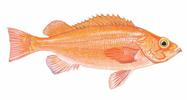




========== Recommending with PCA ==============




	Swordfish | similarity = 0.966


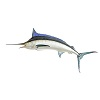


	Haddock | similarity = 0.845


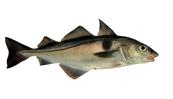


	Blue Crab | similarity = 0.821


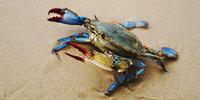


	Scallops | similarity = 0.815


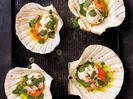


	Shrimp | similarity = 0.808


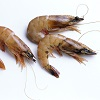

In [154]:
import os
from IPython.display import Image

recommend_to = 48
print("For:\t\t", names[recommend_to])
fn = f'../../datasets/nutr_img/{names[recommend_to].lower()}.jpg'
if os.path.exists(fn):
    display(Image(filename=fn))

print("\n\n\n========== Recommending with PCA ==============\n\n\n")
r = find_k_closest(A_pca_norm[recommend_to,:], A_pca_norm)

for k in r:
    if recommend_to != k: # exclude itself 
        print(f"\n\t{names[k]} | similarity = { np.dot(A_pca_norm[k],  A_pca_norm[recommend_to]) :.3}")
        fn = f'../../datasets/nutr_img/{names[k].lower()}.jpg'
        if os.path.exists(fn):
            display(Image(filename=fn))




========== Recommending with SVD ==============




	Swordfish | similarity = 1.0


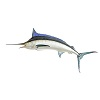


	Pollock | similarity = 1.0


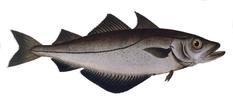


	Haddock | similarity = 0.999


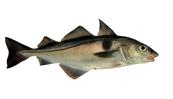


	Flounder | similarity = 0.998


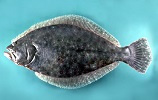


	Clams | similarity = 0.995


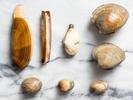

In [155]:
print("\n\n\n========== Recommending with SVD ==============\n\n\n")
r = find_k_closest(A_svd_norm[recommend_to,:], A_svd_norm)
for k in r:
    fn = f'../../datasets/nutr_img/{names[k].lower()}.jpg'
    if recommend_to != k: # exclude itself 
        print(f"\n\t{names[k]} | similarity = { np.dot(A_svd_norm[k],  A_svd_norm[recommend_to]) :.3}")
        if os.path.exists(fn):
            display(Image(filename=fn))

# 2. [60] Evolving vector-space model
This part will be devoted to the use of ML model for the needs of information retrieval and text classification.  

### **Searching in the curious facts database**

The facts dataset is given [here](https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/facts.txt), take a look. We want you to retrieve facts **relevant to the query** (whatever it means), for example, you type "good mood", and get to know that Cherophobia is the fear of fun. For this, the idea is to utilize document vectors. However, instead of forming vectors with tf-idf and reducing dimensions, this time we want to obtain fixed-size vectors for documents using ML model.

## 2.1. [15] Use neural networks to embed sentences

Make use of any, starting from doc2vec up to Transformers, etc. Provide all code, dependencies, installation requirements.


- [UCE in spacy 2](https://spacy.io/universe/project/spacy-universal-sentence-encoder) (`!pip install spacy-universal-sentence-encoder`)
- [Sentence BERT in spacy 2](https://spacy.io/universe/project/spacy-sentence-bert) (`!pip install spacy-sentence-bert`)
- [Pretrained 🤗 Transformers](https://huggingface.co/transformers/pretrained_models.html)
- [Spacy 3 transformers](https://spacy.io/usage/embeddings-transformers#transformers-installation)
- [doc2vec pretrained](https://github.com/jhlau/doc2vec)
- [Some more sentence transformers](https://www.sbert.net/docs/quickstart.html)

Here should be dependency installation, download instructions and so on. With outputs.

In [173]:
!pip install gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to /Users/alla/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/alla/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
corpus = api.load("text8")

In [ ]:
model = Word2Vec(corpus)

## 2.2. [10] Write a function that prepares embedding

Write a function, which returns a fixed-sized vector of embedding.

In [230]:
stopWords = set(stopwords.words('english'))
wnl = nltk.WordNetLemmatizer()
embeddings = model.wv

def preproc_nltk(text):
    #text = re.sub(f'[{string.punctuation}]', ' ', text)
    return ' '.join([wnl.lemmatize(word) for word in word_tokenize(text.lower()) if word not in stopWords])

def embed(text):
    #TODO return a fixed-sized vector of embedding
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')

    count = 0
    for word in preproc_nltk(text).split():
        if word in embeddings:
            features += embeddings[f'{word}']
        count += 1
    
    return features / count

In [231]:
assert len(embed("Some random text")) == len(embed("Folks, here's a story about Minnie the Moocher. She was a lowdown hoochie coocher. She was the roughest, toughest frail, but Minnie had a heart as big as a whale")), "Length should match"

In [232]:
from scipy.spatial.distance import cosine

assert abs(cosine(
            embed("some text for testing"), 
            embed("some text for testing")
        )) < 1e-4, "Embedding should match"

assert abs(cosine(
            embed("Cats eat mice."), 
            embed("Terminator is an autonomous cyborg, typically humanoid, originally conceived as a virtually indestructible soldier, infiltrator, and assassin.")
        )) > 0.2, "Embeddings should be far"

## 2.3. [5] Reading the data

Now, let's read the facts dataset. Download it from the abovementioned url and read to the list of sentences.

In [233]:
import urllib
url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/facts.txt"

file = urllib.request.urlopen(url)
facts = []

for line in file:
    decoded_line = line.decode("utf-8")
    facts.append(decoded_line)

In [234]:
print(*facts[:5], sep='\n')

assert len(facts) == 159
assert ('our lovely little planet') in facts[0]

1. If you somehow found a way to extract all of the gold from the bubbling core of our lovely little planet, you would be able to cover all of the land in a layer of gold up to your knees.

2. McDonalds calls frequent buyers of their food "heavy users."

3. The average person spends 6 months of their lifetime waiting on a red light to turn green.

4. The largest recorded snowflake was in Keogh, MT during year 1887, and was 15 inches wide.

5. You burn more calories sleeping than you do watching television.



## 2.4. [10] Transforming sentences to vectors

Transform the list of facts to `numpy.array` of vectors corresponding to each document (`sent_vecs`), inferring them from the model we just loaded.

In [235]:
sent_vecs = []
for fact in facts:
    sent_vecs.append(embed(fact))
sent_vecs = np.array(sent_vecs)

In [236]:
assert sent_vecs.shape[0] == len(facts)

## 2.5. [10] Find closest

Now find 5 facts which are closest to the query using cosine similarity measure.

In [250]:
#TODO output closest facts to the query
from sklearn.metrics.pairwise import cosine_similarity
query = "good mood"
k = 5

sent_temp = []
for i, sent in enumerate(sent_vecs):
    sent_temp.append((sent, i))

sorted_sentences = sorted(sent_temp, key=lambda x: cosine_similarity(embed(query).reshape(1, -1), x[0].reshape(1, -1))[0][0], reverse=True)
sorted_sentences = list(map(lambda x: x[1], sorted_sentences[:k]))

print("Results for query:", query)
for i in sorted_sentences:
    print("\t", facts[i])

Results for query: good mood
	 60. It is considered good luck in Japan when a sumo wrestler makes your baby cry.

	 119. Dogs are capable of understanding up to 250 words and gestures and have demonstrated the ability to do simple mathematical calculations.

	 151. Women have twice as many pain receptors on their body than men. But a much higher pain tolerance.

	 68. Cherophobia is the fear of fun.

	 2. McDonalds calls frequent buyers of their food "heavy users."



## 2.6. [10] Measure DCG@5 for the following query bucket
```
good mood
gorilla
woman
earth
japan
people
math
```

Recommend 5 facts to each of the queries. Write your code below.

In [262]:
queries = ["good mood", "gorilla", "woman", "earth", "japan", "people", "math"]
scores = []
k = 5

for query in queries:
    sent_temp = []
    for i, sent in enumerate(sent_vecs):
        sent_temp.append((sent, i))

    sorted_sentences = sorted(sent_temp, key=lambda x: cosine_similarity(embed(query).reshape(1, -1), x[0].reshape(1, -1))[0][0], reverse=True)
    query_scores = list(map(lambda x: (cosine_similarity(embed(query).reshape(1, -1), x[0].reshape(1, -1))[0][0] + 1)/2, sorted_sentences[:k]))
    scores.append(query_scores)
    sorted_sentences = list(map(lambda x: x[1], sorted_sentences[:k]))        

    print(query)
    for i in sorted_sentences:
        print("\t", facts[i])

good mood
	 60. It is considered good luck in Japan when a sumo wrestler makes your baby cry.

	 119. Dogs are capable of understanding up to 250 words and gestures and have demonstrated the ability to do simple mathematical calculations.

	 151. Women have twice as many pain receptors on their body than men. But a much higher pain tolerance.

	 68. Cherophobia is the fear of fun.

	 2. McDonalds calls frequent buyers of their food "heavy users."

gorilla
	 121. Birds don't urinate.

	 107. Mountain lions can whistle.

	 47. Avocados are poisonous to birds.

	 113. The tongue of a blue whale weighs more than most elephants!

	 85. The elephant is the only mammal that can't jump!

woman
	 16. Men are 6 times more likely to be struck by lightning than women.

	 146. In France, it is legal to marry a dead person.

	 62. A woman from California once tried to sue the makers of Cap'n Crunch, because the Crunch Berries contained "no berries of any kind."

	 109. Cows kill more people than sha

In [275]:
from sklearn.metrics import dcg_score
dcg_sum = 0
true_and_score = {"good mood": [[[1,0,0,1,0]], [scores[0]]], "gorilla": [[[0,0,0,0,0]], [scores[1]]],
                "woman": [[[1,1,1,0,0]], [scores[2]]], "earth": [[[1,1,1,1,1]], [scores[3]]],
                "japan": [[[1,0,0,0,0]], [scores[4]]], "people": [[[1,1,1,1,1]], [scores[5]]],
                "math": [[[1, 0, 1, 1, 1]], [scores[6]]]}
sum = 0
for word in true_and_score:
    print("DCG@5 score for ", word, " is ", dcg_score(true_and_score[word][0], true_and_score[word][1]))
    sum += dcg_score(true_and_score[word][0], true_and_score[word][1])
print("Average DCG@5 score: ", sum/len(true_and_score))

DCG@5 score for  good mood  is  1.430676558073393
DCG@5 score for  gorilla  is  0.0
DCG@5 score for  woman  is  2.1309297535714573
DCG@5 score for  earth  is  2.948459118879392
DCG@5 score for  japan  is  1.0
DCG@5 score for  people  is  2.948459118879392
DCG@5 score for  math  is  2.3175293653079345
Average DCG@5 score:  1.8251505592445096


## 2.7. [BONUS] Write your own relevance assessments and compute DCG@5

In [281]:
from math import log
#TODO add assesment
assessment = {"good mood": [[[1,0,0,1,0]], [scores[0]]], "gorilla": [[[0,0,0,0,0]], [scores[1]]],
                "woman": [[[1,1,1,0,0]], [scores[2]]], "earth": [[[1,1,1,1,1]], [scores[3]]],
                "japan": [[[1,0,0,0,0]], [scores[4]]], "people": [[[1,1,1,1,1]], [scores[5]]],
                "math": [[[1, 0, 1, 1, 1]], [scores[6]]]}

def dcg(rels):
    res = 0
    for i, v in enumerate(rels):
        res += v / log((i+2), 2)
    return res

np.sum([dcg(assessment[query][1][0]) for query in assessment]) / len(assessment)

2.272785108658115